In [1]:
import pandas as pd
import get_data as gd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from os import walk
import csv
from pychadwick.chadwick import Chadwick  
#https://github.com/jldbc/pybaseball
#https://baseballsavant.mlb.com/csv-docs
from pybaseball import statcast_pitcher
import seaborn as sns
from pybaseball import statcast
import statsmodels.api as sm
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format

# Runs & Wins

The goal of any baseball team is to win as many games as you can, which you do by scoring more runs than you allow. Therefore like they say in MOneyball "Runs is the currency of winning". What this means is when you want to evaluating a player you don't need to neccessarily try and figure out how much they contribute to winning percentage, rather you can focus on how they contribute to runs scored/allowed and use that as a proxy.

The goal of this section is to explore the relationship between runs and wins.

## Getting & Cleaning the Data

We will use the Lahman dataset and look at the relationship between runs and wins for teams from the 2000 to 2019 seasons.

After getting the data we do a bit of feature creation by finding the runs scored and runs allowed per game, as well the win percentage.

In [2]:
teams_df = gd.make_df("Teams") 
teams_df = teams_df[(teams_df['yearID'] >= 2000) & (teams_df['yearID'] < 2020)]
teams_df['Win Percentage'] = teams_df['W']/teams_df['G']
teams_df['Runs Per Game'] = teams_df['R']/teams_df['G']
teams_df['Runs Allowed Per Game'] = teams_df['RA']/teams_df['G'] 

## Looking at the Data

We graph a simple scatter plot of runs score and runs allowed vs win percentage, this gives us an idea of the correlation between each of these variable and win percentage.

As you would expect runs are positive correlated and runs allowed are negatively correlated.

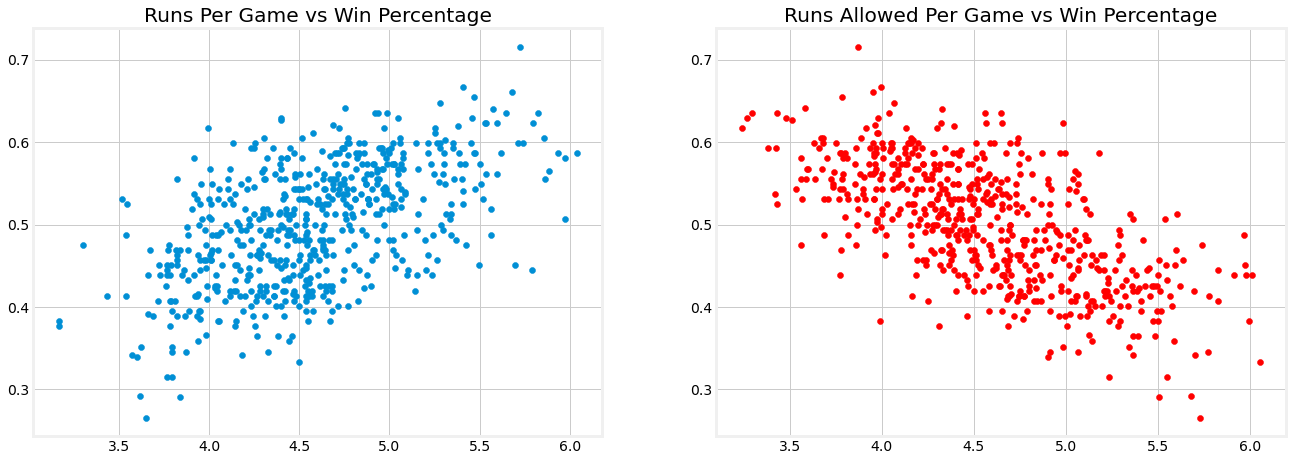

In [3]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,7))

gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax1.scatter(teams_df['Runs Per Game'], teams_df['Win Percentage'])
ax1.set_title('Runs Per Game vs Win Percentage')

fig.patch.set_facecolor('white')
ax2.set_facecolor('white')
ax2.scatter(teams_df['Runs Allowed Per Game'], teams_df['Win Percentage'], color='red')
ax2.set_title('Runs Allowed Per Game vs Win Percentage')
plt.show()

## First Method: OLS

The first method we use to look at the reltionship is running and Oridarny Least Squares (OLS). I like to start with OLS models as they typically perform pretty well and give you a good baseline to compare against.

It will find the relationship between our independent variables (Runs and Runs Allowed) and dependent variable (Win Percentage) which gets the square or the errors as low as possible.

When you look at the coefficients you can read it as a one unit increase in that variable will result in that much of a change in the win percentage. So for example, an increae of 1 run per game for a team should result in an increase in their win percentage of 9.6% while an increase of 1 run allowed per game should decrease the win percentage by 10.2%. The confidence intervals give us the range of the coefficients we could reasonable expect.

A disadvantage of an OLS is it doesn't know that a win rate can't be higher than one or lower than zero. This will be something we tackle with the next method.

In [4]:
teams_df['Intercept'] = 1
y = teams_df['Win Percentage']
X = teams_df[['Runs Per Game','Runs Allowed Per Game','Intercept']]
full_model = sm.OLS(y, X, hasconst=True).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Win Percentage   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     2255.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):          5.46e-279
Time:                        16:05:41   Log-Likelihood:                 1366.1
No. Observations:                 600   AIC:                            -2726.
Df Residuals:                     597   BIC:                            -2713.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Runs Per Game             0.09

## OLS Residuals

### Residual Graphs

A residual is the difference between the predicted and actual value. 

Below we create a facet graph that shows the histogram of residuals as well as a predicted vs residual plot. For the histogram you want to see a normal distribution clustered close to zero, for the scatter plot you want to see no relationship between the prediction and the residual.

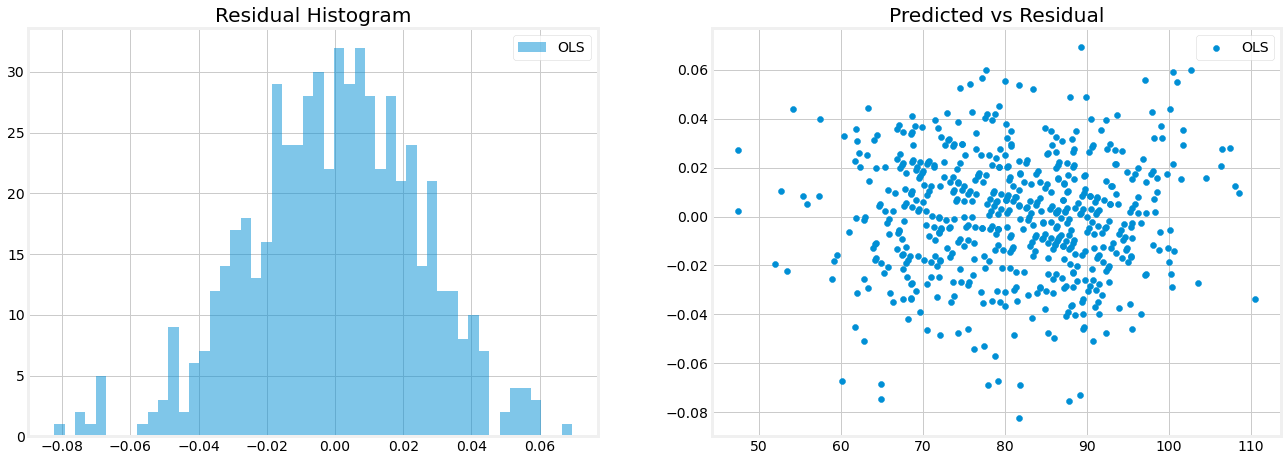

In [5]:
prediction = full_model.predict(teams_df[['Runs Per Game','Runs Allowed Per Game','Intercept']])
teams_df['OLS Win Prediction'] = teams_df['G'] * prediction
teams_df['OLS Residual'] = prediction - teams_df['Win Percentage']
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,7))
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax1.hist(teams_df['OLS Residual'], alpha = 0.5, bins=50, label = 'OLS')
ax1.set_title('Residual Histogram')
ax1.legend()
ax1.legend(facecolor='white')

fig.patch.set_facecolor('white')
ax2.set_facecolor('white')
ax2.scatter(teams_df['OLS Win Prediction'], teams_df['OLS Residual'], label='OLS')
ax2.set_title('Predicted vs Residual')
ax2.legend()
ax2.legend(facecolor='white')

plt.show()

#### Residual Summary Stats

Pandas has a handy built in function called describe, it provides you some good summary stats for the column you pass it. We can see the OLS residuals have a mean of 0 with 50% of the observations having an error of 2%. Again we are just using the OLS model to baseline against more advanced models, so to accept a more complex model it should outperform the simple OLS.

In [6]:
teams_df[['OLS Residual']].describe()

,OLS Residual
count,600.00
mean,-0.00
std,0.02
min,-0.08
25%,-0.02
50%,0.00
75%,0.02
max,0.07


#### Metric for Comparision

There are a few different metrics to compare regressions against each other, a commonly used and simple one is the Sum of Squares Residuals (SSR). Simple put you square the residuals and add them up. This is actually what an OLS is trying to minimize. It also serves as a base for other common metrics such as R^2.

In [7]:
teams_df[['OLS Residual']].apply(lambda x: x**2).sum()

OLS Residual   0.37
dtype: float64

## Second Method: Logit Regression

A logit regression solves for the issue of win percentage being constrainted between 0 to 1, it does this with a minor sacrfice for understandablility (at least for me).

A good way to think of a logit regression, is it performs a transformation of the data to model the relationship between our independent variables and the odd's ratio of our dependent. The exact transformation is outlined below:

logit(p) = log(p/(1-p)) = B0 + B1*(Runs Scored Per Game) + B2*(Runs Scored Per Game) 

So when we get the regression output, we can take the exponent of the coefficients and find their relationship to the odd's ratio. A coefficient of greater than one means it positively increases the chances and below one means it decreases the chances.

In [8]:
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.674688
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         Win Percentage   No. Observations:                  600
Model:                          Logit   Df Residuals:                      597
Method:                           MLE   Df Model:                            2
Date:                Mon, 05 Apr 2021   Pseudo R-squ.:                 0.02663
Time:                        16:05:42   Log-Likelihood:                -404.81
converged:                       True   LL-Null:                       -415.89
Covariance Type:            nonrobust   LLR p-value:                 1.549e-05
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Runs Per Game             0.3924      0.164      2.387      0.017       0.070       0.

Runs per game has a coefficient of 1.48, means an extra run per game increases the odds of winning by close to 50%. While getting an extra run scored against you decreases your odds of winning by almost 40%.

In [9]:
np.exp(logit_model.params)

Runs Per Game           1.48
Runs Allowed Per Game   0.66
Intercept               1.11
dtype: float64

## Residuals 
### Graphs

Looking at the histogram it appears the Logit Regressions (Red) is a bit tighter (closer to zero) than the OLS regression (blue). The scatter plot between the two look very similiar, which is a good thing as neither shows a reltionship between the fitted and residuals.

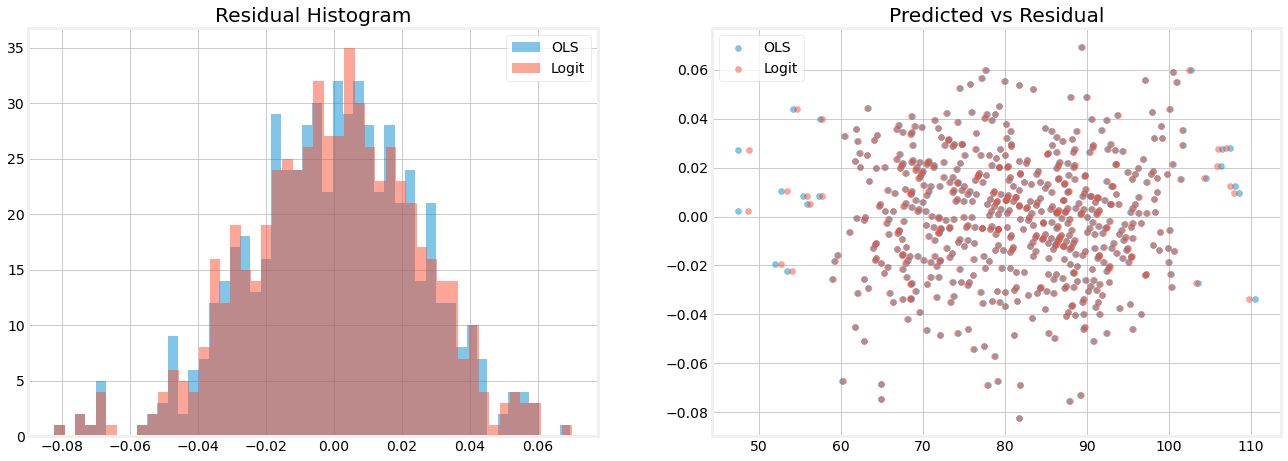

In [10]:
prediction = logit_model.predict(X)
#res = prediction - teams_df['Win Percentage']
teams_df['Logit Win Prediction'] = teams_df['G'] * prediction
teams_df['Logit Residual'] = prediction - teams_df['Win Percentage']

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,7))
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax1.hist(teams_df['OLS Residual'], alpha = 0.5, bins=50, label = 'OLS')
ax1.hist(teams_df['Logit Residual'], alpha = 0.5, bins=50, label = 'Logit')
ax1.set_title('Residual Histogram')
ax1.legend()
ax1.legend(facecolor='white')

fig.patch.set_facecolor('white')
ax2.set_facecolor('white')
ax2.scatter(teams_df['OLS Win Prediction'], teams_df['OLS Residual'], alpha=0.5, label='OLS')
ax2.scatter(teams_df['Logit Win Prediction'], teams_df['OLS Residual'], alpha=0.5, label='Logit')
ax2.set_title('Predicted vs Residual')
ax2.legend()
ax2.legend(facecolor='white')

plt.show()

### Summary Stats

To two decimal spots the Logit does not seem to outperform the OLS, all the key statistics are roughly the same

In [11]:
teams_df[['OLS Residual', 'Logit Residual']].describe()

,OLS Residual,Logit Residual
count,600.00,600.00
mean,-0.00,0.00
std,0.02,0.02
min,-0.08,-0.08
25%,-0.02,-0.02
50%,0.00,0.00
75%,0.02,0.02
max,0.07,0.07


### Sum of Squares

Again to two decimal spots the OLS and the Logit are the exact same. From this I would lean towards keeping the OLS model as the Logit does no seem to outperform. This is likely because the corner cases of a prediction above 1 or below zero is not occurinng in the OLS model.

In [12]:
teams_df[['OLS Residual', 'Logit Residual']].apply(lambda x: x**2).sum()

OLS Residual     0.37
Logit Residual   0.37
dtype: float64

## Pythrongan Formula for Winning Percentage

Bill James developed a something called the Pythagorean Formula which uses a formula of Runs and Runs Allowed to estimate a teams winning percentage.

The formula has some nice propertieis, namely it will constrain the prediction of a win rate to be between 0 and 1. It is also simple and easy to understand. 

Lets compare this to the OLS model and see if it outperforms.

### Residual Graphs

Comapring the histograms is a bit interesting. The Pythagorean formula has a wider ranges but does shift some data closer to 0.

The residual plot again look similiar for both models

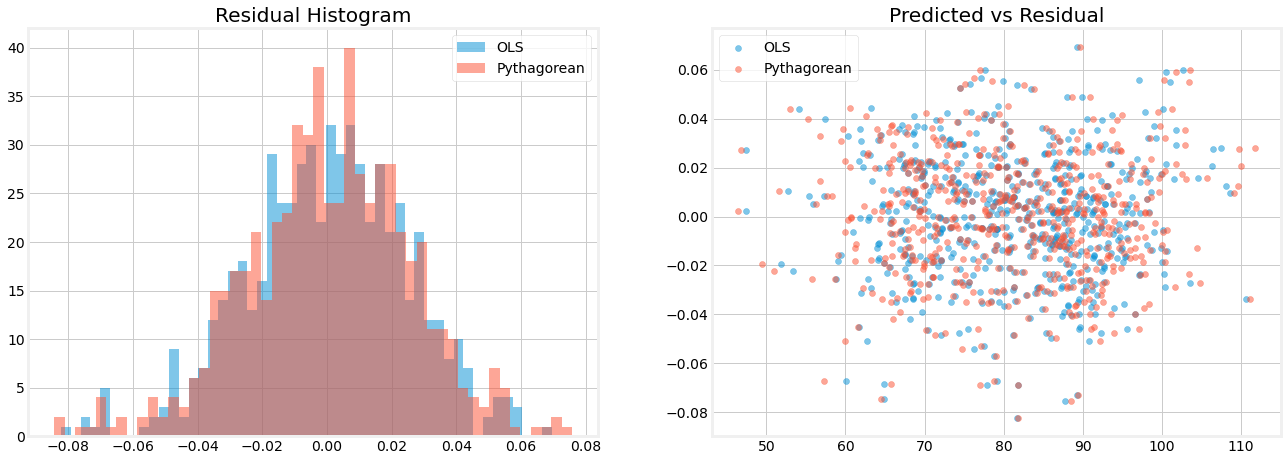

In [13]:
prediction = teams_df['R']**2/(teams_df['R']**2 + teams_df['RA']**2)
teams_df['Pythagorean Win Prediction'] = teams_df['G'] * prediction
teams_df['Pythagorean Residual'] = prediction - teams_df['Win Percentage']

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,7))
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax1.hist(teams_df['OLS Residual'], alpha = 0.5, bins=50, label = 'OLS')
ax1.hist(teams_df['Pythagorean Residual'], alpha = 0.5, bins=50, label = 'Pythagorean')
ax1.set_title('Residual Histogram')
ax1.legend()
ax1.legend(facecolor='white')

fig.patch.set_facecolor('white')
ax2.set_facecolor('white')
ax2.scatter(teams_df['OLS Win Prediction'], teams_df['OLS Residual'], alpha=0.5, label='OLS')
ax2.scatter(teams_df['Pythagorean Win Prediction'], teams_df['OLS Residual'], alpha=0.5, label='Pythagorean')
ax2.set_title('Predicted vs Residual')
ax2.legend()
ax2.legend(facecolor='white')

plt.show()

### Summary Stats

Looking at the summary stats it confirms that the Pythagorean does have a higher range and standard deviation compared to the Logit or OLS. Generally speaking this means the Pythagorean is wrong by a larger margin than the other models.

In [14]:
teams_df[['OLS Residual', 'Logit Residual', 'Pythagorean Residual']].describe()

,OLS Residual,Logit Residual,Pythagorean Residual
count,600.00,600.00,600.00
mean,-0.00,0.00,0.00
std,0.02,0.02,0.03
min,-0.08,-0.08,-0.08
25%,-0.02,-0.02,-0.02
50%,0.00,0.00,0.00
75%,0.02,0.02,0.02
max,0.07,0.07,0.08


### Sum of Squares

As expected the Pythagorean performs the worst. Overall, the findings should not be to surprising. Part of the attraction of the Pythagorean formula is how easy to remeber. Part of that is driven by the fact that the exponents are all two, which was probably picked because they were the closest round number to the acual appropriate one. In the next model we will see if we can find the correct values and see how that improves performance

In [15]:
teams_df[['OLS Residual', 'Logit Residual', 'Pythagorean Residual']].apply(lambda x: x**2).sum()

OLS Residual           0.37
Logit Residual         0.37
Pythagorean Residual   0.39
dtype: float64

## Update Pythagorean

With a bit fo alegbra we can show that the Pyhtagorean can be shown as W/L = (R/RA)^K, where K = 2. Applying a log to both sides we get log(W/L) = K * log(R/RA). We can use an OLS to estimate what K should be.

In [16]:
y = np.log(teams_df['W']/teams_df['L'])
X = np.log(teams_df['R']/teams_df['RA'])
py_model = sm.OLS(y, X, hasconst=False).fit()
print(py_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.880
Method:                 Least Squares   F-statistic:                              4396.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):                   4.58e-278
Time:                        16:05:49   Log-Likelihood:                          514.93
No. Observations:                 600   AIC:                                     -1028.
Df Residuals:                     599   BIC:                                     -1023.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Graphs

Using the new exponent of 1.8508 we can see how the updated version performs. We can immediatly see the range has been tightened up with errors closers to zero.

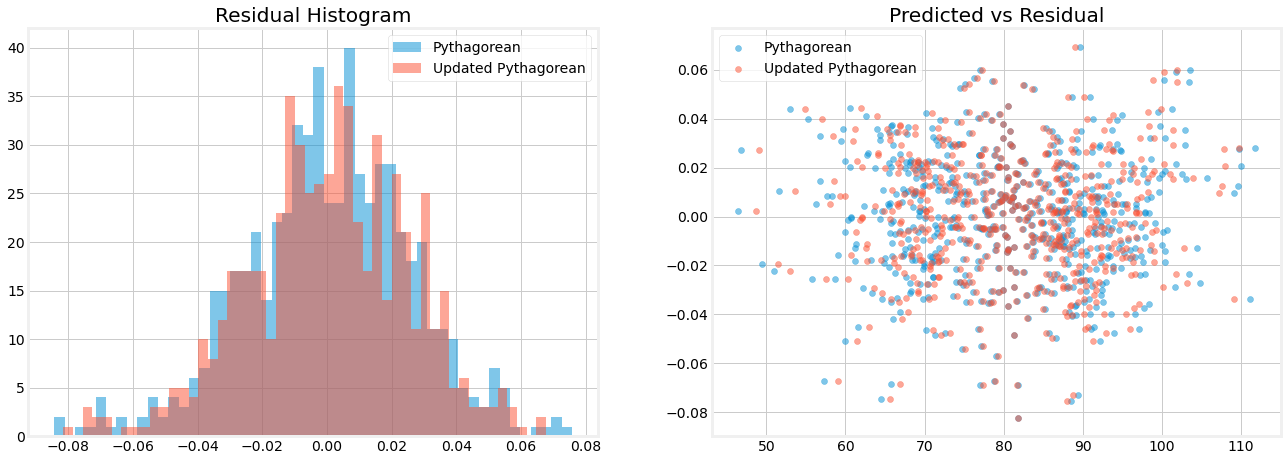

In [17]:
exponent = 1.8508
prediction = teams_df['R']**exponent/(teams_df['R']**exponent + teams_df['RA']**exponent)
teams_df['Updated Pythagorean Win Prediction'] = teams_df['G'] * prediction
teams_df['Updated Pythagorean Residual'] = prediction - teams_df['Win Percentage']

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,7))
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax1.hist(teams_df['Pythagorean Residual'], alpha = 0.5, bins=50, label = 'Pythagorean')
ax1.hist(teams_df['Updated Pythagorean Residual'], alpha = 0.5, bins=50, label = 'Updated Pythagorean')
ax1.set_title('Residual Histogram')
ax1.legend()
ax1.legend(facecolor='white')

fig.patch.set_facecolor('white')
ax2.set_facecolor('white')
ax2.scatter(teams_df['Pythagorean Win Prediction'], teams_df['OLS Residual'], alpha=0.5, label='Pythagorean')
ax2.scatter(teams_df['Updated Pythagorean Win Prediction'], teams_df['OLS Residual'], alpha=0.5, label='Updated Pythagorean')
ax2.set_title('Predicted vs Residual')
ax2.legend()
ax2.legend(facecolor='white')

plt.show()

### Summary Stats

The Updated Pythagorean has some interesting findings. Overall it outperforms the Pythagorean across the board. Comparing to the OLS and Logit is interesting though. The mean errors and zero for all, with the Updated Pythagorean having a higher standard deviation than the OLS/Logit. However it has a smaller Interquartile Range (difference between 25th and 75th percentile).

In [18]:
teams_df[['OLS Residual', 'Logit Residual', 'Pythagorean Residual','Updated Pythagorean Residual']].describe()

,OLS Residual,Logit Residual,Pythagorean Residual,Updated Pythagorean Residual
count,600.00,600.00,600.00,600.00
mean,-0.00,0.00,0.00,0.00
std,0.02,0.02,0.03,0.03
min,-0.08,-0.08,-0.08,-0.08
25%,-0.02,-0.02,-0.02,-0.01
50%,0.00,0.00,0.00,0.00
75%,0.02,0.02,0.02,0.02
max,0.07,0.07,0.08,0.07


### Sum of Squares

Even with the updating the Pythagorean fails to outperform the OLS or Logit models.

In [19]:
teams_df[['OLS Residual', 
          'Logit Residual', 
          'Pythagorean Residual',
          'Updated Pythagorean Residual']].apply(lambda x: x**2).sum()

OLS Residual                   0.37
Logit Residual                 0.37
Pythagorean Residual           0.39
Updated Pythagorean Residual   0.38
dtype: float64

## Over and Under Performers

Sorting the data by the OLS residuals we can see which teams over and underperformed the model by the highest margin.

2016 Texas Rangers had 95 wins in the season, but based on their runs we would have expected them to only get 82.

On the flip side the 2015 Toronto Blue Jays has 93 wins, but based on their runs we would have expected close to 103.

In the next sections we will do some digging into what are some potential causes for the under and over performance for these two teams.

In [20]:
teams_df.sort_values(by='OLS Residual')[['yearID', 
                                                 'teamID', 
                                                 'W', 
                                                 'R',
                                                 'RA',
                                                 'OLS Win Prediction', 
                                                 'Logit Win Prediction', 
                                                 'Pythagorean Win Prediction',
                                                 'Updated Pythagorean Win Prediction']]

,yearID,teamID,W,R,RA,OLS Win Prediction,Logit Win Prediction,Pythagorean Win Prediction,Updated Pythagorean Win Prediction
2832,2016,TEX,95,765,757,81.67,81.68,81.85,81.79
2578,2008,LAA,100,765,697,87.79,87.88,88.52,87.96
2475,2005,ARI,77,696,856,64.91,64.86,64.47,65.68
2463,2004,NYA,101,897,808,89.21,89.31,89.43,88.81
2687,2012,BAL,93,712,705,81.86,81.87,81.80,81.74
...,...,...,...,...,...,...,...,...,...
2831,2016,TBA,68,672,713,77.19,77.12,76.21,76.57
2852,2017,NYA,91,858,660,100.54,100.47,101.78,100.29
2794,2015,OAK,68,694,729,77.68,77.62,77.02,77.31
2803,2015,TOR,93,891,670,102.71,102.53,103.48,101.89


In [ ]:
#https://en.wikipedia.org/wiki/2014_Oakland_Athletics_season

In [21]:
games_df_2015 = gd.make_gamelog_df(2015)
games_df_2016 = gd.make_gamelog_df(2016)

In [23]:
games_df_2015_tor = games_df_2015[(games_df_2015['VisitingTeam'] == 'TOR') | (games_df_2015['HomeTeam'] == 'TOR')]
games_df_2016_tex = games_df_2015[(games_df_2015['VisitingTeam'] == 'TEX') | (games_df_2015['HomeTeam'] == 'TOR')]

In [24]:
games_df_2015_tor

,Date,DoubleHeader,DayOfWeek,VisitingTeam,VisitingTeamLeague,VisitingTeamGameNumber,HomeTeam,HomeTeamLeague,HomeTeamGameNumber,VisitorRunsScored,...,HomeBatting7Name,HomeBatting7Position,HomeBatting8PlayerID,HomeBatting8Name,HomeBatting8Position,HomeBatting9PlayerID,HomeBatting9Name,HomeBatting9Position,AdditionalInfo,AcquisitionInfo
4,20150406,0,Mon,TOR,AL,1,NYA,AL,1,6,...,Alex Rodriguez,10,drews001,Stephen Drew,4,gregd001,Didi Gregorius,6,NaN,Y
25,20150408,0,Wed,TOR,AL,2,NYA,AL,2,3,...,Alex Rodriguez,10,drews001,Stephen Drew,4,gregd001,Didi Gregorius,6,NaN,Y
40,20150409,0,Thu,TOR,AL,3,NYA,AL,3,6,...,John Ryan Murphy,2,petig001,Gregorio Petit,4,gregd001,Didi Gregorius,6,NaN,Y
47,20150410,0,Fri,TOR,AL,4,BAL,AL,4,12,...,Travis Snider,9,schoj001,Jonathan Schoop,4,josec002,Caleb Joseph,2,NaN,Y
62,20150411,0,Sat,TOR,AL,5,BAL,AL,5,1,...,Jonathan Schoop,4,cabre001,Everth Cabrera,6,josec002,Caleb Joseph,2,NaN,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2356,20150930,2,Wed,TOR,AL,158,BAL,AL,158,1,...,Steve Pearce,3,flahr001,Ryan Flaherty,9,hardj003,J.J. Hardy,6,NaN,Y
2372,20151001,0,Thu,TOR,AL,159,BAL,AL,159,4,...,J.J. Hardy,6,flahr001,Ryan Flaherty,9,josec002,Caleb Joseph,2,NaN,Y
2388,20151002,0,Fri,TOR,AL,160,TBA,AL,160,8,...,Richie Shaffer,3,frann001,Nick Franklin,4,maill001,Luke Maile,2,NaN,Y
2402,20151003,0,Sat,TOR,AL,161,TBA,AL,161,3,...,Tim Beckham,4,kierk001,Kevin Kiermaier,8,river003,Rene Rivera,2,NaN,Y
